In [1]:
import tensorflow as tf
import numpy as np
import transformers
import datasets

In [4]:
print(tf.__version__)
print(np.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


#### step1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [21]:
from datasets import load_dataset
from datasets import list_datasets, load_dataset, list_metrics, load_metric
from huggingface_hub.hf_api import HfFolder


huggingface_nsmc_dataset = load_dataset('nsmc')
print(huggingface_nsmc_dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [22]:
train = huggingface_nsmc_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [23]:
train

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 150000
})

In [24]:
test = huggingface_nsmc_dataset['test']
test

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 50000
})

In [25]:
#train
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




In [26]:
#test
for i in range(5):
    for col in cols:
        print(col, ":", test[col][i])
    print('\n')

id : 6270596
document : 굳 ㅋ
label : 1


id : 9274899
document : GDNTOPCLASSINTHECLUB
label : 0


id : 8544678
document : 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
label : 0


id : 6825595
document : 지루하지는 않은데 완전 막장임... 돈주고 보기에는....
label : 0


id : 6723715
document : 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
label : 0




#### step2. Klue/bert-base model 및 tokenizer 불러오기

In [27]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = "klue/bert-base"
num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [51]:
tokenizer('배고프고 힘들다')

{'input_ids': [2, 23044, 2088, 4390, 2062, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

#### step3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해보기

In [28]:
import pandas as pd
len(train['document'])

train_dataset = pd.DataFrame({'id':train['id'],
                             'document':train['document'],
                             'label':train['label']})

test_dataset_none = pd.DataFrame({'id':test['id'],
                             'document':test['document'],
                             'label':test['label']})

# student_card
train_dataset[:5]
val_dataset = test_dataset_none[:int(len(test_dataset_none)/2)]
test_dataset = test_dataset_none[int(len(test_dataset_none)/2):]

In [29]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

150000
25000
25000


In [30]:
train_dataset

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [48]:
train_dataset['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


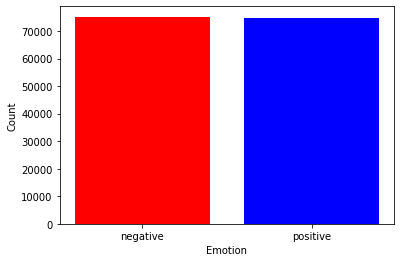

In [50]:
import matplotlib.pyplot as plt

label_counts = train_dataset['label'].value_counts()
label_names = ['negative','positive']
plt.figure(figsize=(6,4))
plt.bar(label_names, label_counts, color=['red','blue'])
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

=> label의 분포 확인 결과 불균형없음을 확인

In [31]:
from datasets import Dataset

# DataFrame 데이터를 dict 내부에 list로 변경
train_dataset = train_dataset.to_dict(orient='list')
val_dataset = val_dataset.to_dict('list')
test_dataset = test_dataset.to_dict('list')

# Hugging Face dataset으로 변환
tf_train_dataset = Dataset.from_dict(train_dataset)
tf_val_dataset = Dataset.from_dict(val_dataset)
tf_test_dataset = Dataset.from_dict(test_dataset)

In [32]:
from datasets import Dataset, DatasetDict

# 분할된 데이터셋을 DatasetDict 형태로 조합
hf_dataset_dict = DatasetDict({
    'train': tf_train_dataset,
    'validation': tf_val_dataset,
    'test': tf_test_dataset
})

In [33]:
hf_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    validation: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 25000
    })
})

In [34]:
# 훈련데이터로부터 샘플을 불러와 토크나이저 적용

# 변환 함수 정의
def transform(data):
    return tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        max_length = 80,
        return_token_type_ids=False,
    )

In [36]:
hf_dataset = huggingface_nsmc_dataset.map(transform, batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [37]:
hf_dataset = hf_dataset_dict.map(transform, batched=True)

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [42]:
from datasets import load_metric
metric = load_metric('glue', 'mrpc')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [38]:
# 훈련, 검증, 테스트 데이터셋 분할
hf_train_dataset = hf_dataset['train']
hf_val_dataset = hf_dataset['validation']
hf_test_dataset = hf_dataset['test']

시간을 고려해서 epoch과 batch_size를 대폭 줄여서 실험을 진행
- batch_size=4
- epoch = 1

In [52]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 4,   # 각 device 당 batch size
    per_device_eval_batch_size = 4,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.005,                        # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [53]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

In [54]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 150000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 37500


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.419600,0.430858,0.900480,0.901481


Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-500
Configuration saved in /aiffel/aiffel/prj/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-1000
Configuration saved in /aiffel/aiffel/prj/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-1500
Configuration saved in /aiffel/aiffel/prj/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-2000
Configuration saved in /aiffel/aiffel/prj/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-2500
Configuration saved in /aiffel/aiffel/prj/checkpoint-2500/config.json
Model weights saved in /aiffel/aiffel/p

TrainOutput(global_step=37500, training_loss=0.2768705303955078, metrics={'train_runtime': 5095.0807, 'train_samples_per_second': 29.44, 'train_steps_per_second': 7.36, 'total_flos': 6166665360000000.0, 'train_loss': 0.2768705303955078, 'epoch': 1.0})

- 훈련 loss : 0.419600
- val loss : 0.430858
- 정확도 : 0.900480
- f1 score : 0.901481

#### step 4. Fine-tuning을 통하여 모델 성능 향상시키기
- 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.

weight_decay를 0.005에서 0.01로 늘려서 실험을 진행해보았다.

In [41]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 4,   # 각 device 당 batch size
    per_device_eval_batch_size = 4,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [43]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

In [44]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 150000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 37500


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.392900,0.384178,0.903400,0.904254


Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-500
Configuration saved in /aiffel/aiffel/prj/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-1000
Configuration saved in /aiffel/aiffel/prj/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-1500
Configuration saved in /aiffel/aiffel/prj/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-2000
Configuration saved in /aiffel/aiffel/prj/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-2500
Configuration saved in /aiffel/aiffel/prj/checkpoint-2500/config.json
Model weights saved in /aiffel/aiffel/p

TrainOutput(global_step=37500, training_loss=0.41807968994140626, metrics={'train_runtime': 4131.1641, 'train_samples_per_second': 36.309, 'train_steps_per_second': 9.077, 'total_flos': 6166665360000000.0, 'train_loss': 0.41807968994140626, 'epoch': 1.0})

- 훈련 loss : 0.392900
- val loss : 0.384178
- accuracy : 0.903400
- F1 score : 0.904254

=> 정규화기법이여서 성능이 아주 약간 향상됨

#### step 5. Bucketing을 적용하여 학습시키고, step 4의 결과와 비교
- 아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.
- STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

In [55]:
from transformers import DataCollatorWithPadding

# 데이터 콜레이터 정의 (Bucketing을 포함한 패딩 적용)
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,  # 사용 중인 토크나이저
    padding=True)  # 패딩을 적용하도록 설정

In [56]:
# 훈련 파라미터 설정
training_args = TrainingArguments(
    output_dir=output_dir,  # 모델과 결과물 저장 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 4,   # 각 device 당 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [58]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    data_collator = data_collator,
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)

In [59]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 150000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 37500
/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.485600,0.478792,0.898040,0.898369


Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-500
Configuration saved in /aiffel/aiffel/prj/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-500/pytorch_model.bin
/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-1000
Configuration saved in /aiffel/aiffel/prj/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/prj/checkpoint-1000/pytorch_model.bin
/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Saving model checkpoint to /aiffel/aiffel/prj/checkpoint-1500
Configuration saved in /aiffe

TrainOutput(global_step=37500, training_loss=0.18389512908935546, metrics={'train_runtime': 5080.867, 'train_samples_per_second': 29.523, 'train_steps_per_second': 7.381, 'total_flos': 6166665360000000.0, 'train_loss': 0.18389512908935546, 'epoch': 1.0})

회고
- 허깅페이스를 통해 트렌스포머 모델을 가져오기 편하고 파인튜닝된 다양한 모델을 쉽게 가져올 수 있다는 점에서 유용하게 쓰이는 이유에 대해서 잘 알 수 있었고 직접 가져와 사용해볼 수 있었다.
- 아직 bucketing을 사용할 경우 성능이 좋아질 거라고 생각했지만 정확도가 떨어진 이유에 대해서는 훈련을 잘못시킨 것 같은데 다시 시간적여유를 가지고 재시도해봐야할 것 같다.